In [1]:
import argparse
import datetime
import logging
import os
import sys
from timeit import default_timer as timer

import tqdm
import utils
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data

In [3]:
K = 40
r = 0.05
sigma = 0.25
T = 1
S_range = [0, 130]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)

# Network

In [4]:
class AdaptiveLinear(nn.Linear):
    r"""Applies a linear transformation to the input data as follows
    :math:`y = naxA^T + b`.
    More details available in Jagtap, A. D. et al. Locally adaptive
    activation functions with slope recovery for deep and
    physics-informed neural networks, Proc. R. Soc. 2020.

    Parameters
    ----------
    in_features : int
        The size of each input sample
    out_features : int 
        The size of each output sample
    bias : bool, optional
        If set to ``False``, the layer will not learn an additive bias
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice 
        (self.A is the learnable parameter which is initialized by the 
        self.adaptive rate. To create a learnable parameter for each neuron, 
        it multiplies the self.adaptive rate to the number of input features.)
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, in_features, out_features, bias=True, adaptive_rate=None, adaptive_rate_scaler=None):
        super(AdaptiveLinear, self).__init__(in_features, out_features, bias)
        self.adaptive_rate = adaptive_rate
        self.adaptive_rate_scaler = adaptive_rate_scaler
        if self.adaptive_rate:
            self.A = nn.Parameter(self.adaptive_rate * torch.ones(self.in_features))
            if not self.adaptive_rate_scaler:
                self.adaptive_rate_scaler = 10.0
            
    def forward(self, input):
        if self.adaptive_rate:
            return nn.functional.linear(self.adaptive_rate_scaler * self.A * input, self.weight, self.bias)
        return nn.functional.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return (
            f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}, '
            f'adaptive_rate={self.adaptive_rate is not None}, adaptive_rate_scaler={self.adaptive_rate_scaler is not None}'
        )



class Net(nn.Module):
    r"""Neural approximator for the unknown function that is supposed
    to be solved.

    More details available in Raissi, M. et al. Physics-informed neural
    networks: A deep learning framework for solving forward and inverse
    problems involving nonlinear partial differential equations, J.
    Comput. Phys. 2019.

    Parameters
    ----------
    sizes : list
        Each element represents the number of neuron per layer
    activation : callable 
        Activation function
    dropout_rate : float, optional
        Dropout rate for regulrization during training process and
        uncertainty quantification by means of Monte Carlo dropout
        procedure while performing evaluation
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, sizes, activation, dropout_rate=0.0, adaptive_rate=None, adaptive_rate_scaler=None):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(
            *[Net.linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler)
            for in_features, out_features in zip(sizes[:-1], sizes[1:-1])],     
            AdaptiveLinear(sizes[-2], sizes[-1]) # output layer is regular linear transformation
            )
        
    def forward(self, x):
        return self.regressor(x)

    @staticmethod
    def linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler):
        activation_dispatcher = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU()],
            ['relu', nn.ReLU()],
            ['tanh', nn.Tanh()],
            ['sigmoid', nn.Sigmoid()],
            # ['swish', Swish()]
        ])
        return nn.Sequential(
            AdaptiveLinear(in_features, out_features, adaptive_rate=adaptive_rate, adaptive_rate_scaler=adaptive_rate_scaler),
            activation_dispatcher[activation],
            nn.Dropout(dropout_rate),
            )



In [5]:
IPINN = Net(
    sizes=[2, 50, 50, 50, 1], activation='relu', dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0
    )
IPINN.cuda()

samples = {"pde": 5000, "bc":500, "fc":500}

# Train

In [6]:
n_epochs = 30000
adaptive_rate = 0.1
lossFunction = nn.MSELoss()
lr = 0.00003
optimizer = optim.Adam(IPINN.parameters(), lr=lr)

- linspace: space the batch of data linearly, otherwise random, type=float
- domain: Boundaries of the solution domain, type=float
- batch_size: The number of adata points for optimization per epoch, type=float
- rhs: right-hand-side forcing function, type=float
- boundary_conditions: boundaru conditions on boundaries of the domain, type=float
- adaptive rate: add additional adaptive rate parameter to activation function, type=float

In [7]:
import time
import torch.autograd as tgrad

loss_hist = []
min_train_loss = float("inf")  # Initialize with a large value
final_model = None
start_time = time.time()

# tqdm.tqdm(range(n_epochs), desc='[Training procedure]', ascii=True, total=n_epochs)

for _ in range(n_epochs):
    i_st_train, i_v_train, bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData3(K, 
                    r, 
                    sigma, 
                    T, 
                    S_range[-1], 
                    S_range, 
                    t_range, 
                    gs, 
                    samples['bc'], 
                    samples['fc'], 
                    samples['pde'], 
                    RNG_key=123)
    
    # save training data points to tensor and send to device
    i_st_train = torch.from_numpy(i_st_train).float().requires_grad_().to(device)
    i_v_train = torch.from_numpy(i_v_train).float().to(device)
    
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)
    
    
    # PDE Round
    y1_hat = IPINN(n_st_train)
    
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), retain_graph=True, create_graph=True, only_inputs=True)[0]
    # print(grads)
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), create_graph=True, only_inputs=True)[0]
    # print(grads2nd)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = n_st_train[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    
    # BC Round
    y21_hat = IPINN(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y21_hat)
    
    # final condition loss
    fc_hat = IPINN(i_st_train)
    fc_loss = lossFunction(i_v_train, fc_hat)
    
    
    
    if adaptive_rate:
        local_recovery_terms = torch.tensor([torch.mean(IPINN.regressor[layer][0].A.data) for layer in range(len(IPINN.regressor) - 1)])
        slope_recovery_term = 1 / torch.mean(torch.exp(local_recovery_terms))
        loss = pde_loss + bc_loss + fc_loss + slope_recovery_term
    else:
        loss = pde_loss + bc_loss + fc_loss
        
        
    
    optimizer.zero_grad()
    loss.backward()
    
    mse_loss = pde_loss + bc_loss + fc_loss
    loss_hist.append(mse_loss.item())
    
    if _ % 500 == 0:
        print(f'{_}/{n_epochs} mse loss: {mse_loss.item():5f}, PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, fc loss: {fc_loss.item():.5f}, reg_loss: {slope_recovery_term.item(): 5f}, min loss: {min(loss_hist):.5f}')
        pass
    
    if mse_loss.item() < min_train_loss:
        final_model = IPINN
        pass

    
    optimizer.step()
        
        
        
elapsed = timer() - start_time
end_time = time.time()
print('run time:', end_time - start_time)
logging.info(f'Training finished. Elapsed time: {elapsed} s\n')

0/30000 mse loss: 5685.587891, PDE Loss: 0.00011, BC Loss: 3988.59668, fc loss: 1696.99109, reg_loss:  0.904837, min loss: 5685.58789
500/30000 mse loss: 2115.968994, PDE Loss: 0.00214, BC Loss: 1561.82861, fc loss: 554.13812, reg_loss:  0.895836, min loss: 2115.96899
1000/30000 mse loss: 212.019516, PDE Loss: 0.06372, BC Loss: 33.22682, fc loss: 178.72897, reg_loss:  0.886647, min loss: 212.01952
1500/30000 mse loss: 173.906982, PDE Loss: 4.77106, BC Loss: 23.60560, fc loss: 145.53032, reg_loss:  0.879651, min loss: 173.90698
2000/30000 mse loss: 142.193756, PDE Loss: 22.79671, BC Loss: 15.44244, fc loss: 103.95460, reg_loss:  0.875356, min loss: 142.19376
2500/30000 mse loss: 127.076744, PDE Loss: 36.55812, BC Loss: 10.80024, fc loss: 79.71838, reg_loss:  0.874506, min loss: 127.07674
3000/30000 mse loss: 112.601067, PDE Loss: 35.44696, BC Loss: 9.18107, fc loss: 67.97304, reg_loss:  0.875700, min loss: 112.60107
3500/30000 mse loss: 91.419586, PDE Loss: 31.33755, BC Loss: 7.14595, f

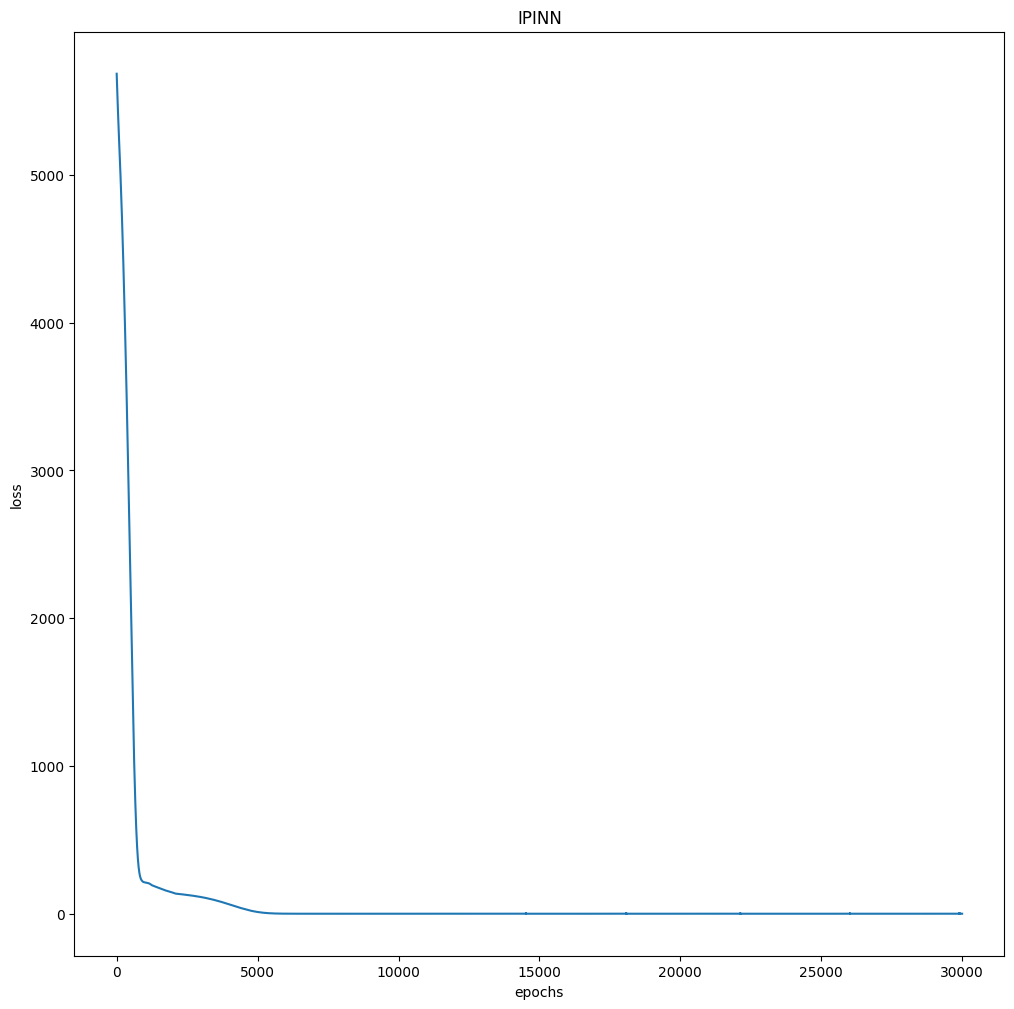

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('IPINN')

torch.save(IPINN.state_dict(), 'IPINN-3.pth')

In [10]:
# model = torch.load('IPINN-3.pth')
print(utils.test(device, final_model))

68.65715026855469
